# Sentiment and Time Series ML with Crypto

In [1]:
# Libraries
from eod import EodHistoricalData
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import nltk
from textblob import TextBlob
import numpy as np
import random
import plotly.express as px
from prophet import Prophet

# Importing and assigning the api key
with open("../../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()
    
# EOD Historical Data client
client = EodHistoricalData(api_key)

# News and Price Data

In [2]:
def getNews(ticker, days):
    """
    Retrieves financial news over the course of a specified number of days for
    a given stock ticker.
    """

    # List of news
    news = []
    
    # How many days back to retrieve
    ago = datetime.now() - timedelta(days=days)

    # Getting news over the course of a year
    for i in tqdm(range(10, days, 10)):

        # Grabbing the news
        resp = client.get_financial_news(
            s=ticker+".CC",
            from_=(ago+timedelta(days=i-10)).strftime("%Y-%m-%d"),
            to=(ago+timedelta(days=i)).strftime("%Y-%m-%d"),
            limit=100
        )

        # Adding to the news list
        news.extend(resp)
                
    # Filtering out irrelevant news
    lst = [i for i in news if sum(x in {ticker.lower()} for x in nltk.word_tokenize(i['title'].lower()))>=1]
    
    # Formatting the date
    news = pd.DataFrame(lst)
    
    news['date'] = news['date'].apply(lambda x: x[:10])
    
    return news

In [3]:
# Retrieving financial news
news = getNews("BTC", 100)

100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


# Sentiment Analysis

In [4]:
def sentimentPositions(val, thresh=0.1):
    """
    Returns position as 1, -1, or 0 for Buy, Sell, 
    and Do Nothing respectively based on the given 
    sentiment value and threshold.
    """
    if val > thresh:
        return 1
    elif val< -thresh:
        return -1
    else:
        return 0

In [142]:
# Getting sentiment values for the news headlines/titles
news['sentiment'] = news['title'].apply(
    lambda x: TextBlob(x.lower()).sentiment[0]
)

# Grouping together dates and aggregating sentiment scores from the same day
sent_df = news.groupby('date')[['sentiment']].mean()

# Applying the position function
sent_df['sentiment_positions'] = sent_df['sentiment'].apply(
    lambda x: sentimentPositions(x, thresh=0)
)

# Filling in missing days with the most recent position value
date_index = [str(i)[:10] for i in pd.date_range(sent_df.index[0], sent_df.index[-1])]

sent_df = sent_df.reindex(date_index).fillna(method='ffill')

In [143]:
sent_df

,sentiment,sentiment_positions
date,,
2021-09-19,0.132955,1.0
2021-09-20,0.125000,1.0
2021-09-21,0.000000,0.0
2021-09-22,0.000000,0.0
2021-09-23,0.000000,0.0
...,...,...
2021-12-06,-0.079167,-1.0
2021-12-07,-0.079167,-1.0
2021-12-08,0.055556,1.0


# FBProphet Time Series Analysis
In order to properly backtest with sentiment, a certain amount of training days need to come before the first date from the sentiment DF

In [56]:
def getPrices(ticker, training_days, sent_df, mov_avg):
    """
    Using a sentiment DataFrame to find the first day and trains with the previous
    N days to make predictions that cooperate with sentiment.
    
    Also prepares the price data for FBProphet.
    """
    # The first day from the sentiment DF minus the amount of days to train with
    ago = datetime.strptime(
        sent_df.index[0], "%Y-%m-%d"
    ) - timedelta(
        days=training_days+mov_avg
    )
    
    # Getting prices
    prices = pd.DataFrame(
        client.get_prices_eod(
            ticker+"-USD.CC", 
            from_=ago.strftime("%Y-%m-%d")
        )
    )

    # Set index
    prices = prices.set_index('date', drop=True)
    
    # Getting the N Day Moving Average and rounding the values for some light data preprocessing
    prices['MA'] = prices[['open']].rolling(
        window=mov_avg
    ).mean().apply(lambda x: round(x, 2))

    # Dropping Nans
    prices.dropna(inplace=True)

    # Resetting format for FBP
    prices = prices.reset_index().rename(
        columns={"date": "ds", "MA": "y"}
    )
    
    return prices

In [87]:
prices = getPrices("BTC", 365, sent_df, 5)

prices

,ds,open,high,low,close,adjusted_close,volume,y
0,2020-09-18,10946.2442,11035.4876,10836.4234,10935.3768,10935.3768,17023995991,10744.65
1,2020-09-19,10949.5601,11142.1776,10920.7426,11095.1677,11095.1677,13759271061,10868.20
2,2020-09-20,11095.1629,11095.1629,10814.1651,10930.4456,10930.4456,14629736360,10950.36
3,2020-09-21,10932.2450,10988.3972,10391.1061,10455.8932,10455.8932,17829479597,10976.97
4,2020-09-22,10452.4406,10572.7500,10390.4856,10549.9413,10549.9413,14486593090,10875.13
...,...,...,...,...,...,...,...,...
455,2021-12-17,47666.5634,47959.7768,45918.0921,46342.6802,46342.6802,38541915812,48378.82
456,2021-12-18,46250.2676,47215.8890,45712.3787,46981.3627,46981.3627,29878025147,47611.26
457,2021-12-19,46906.1835,47990.6863,46582.4147,46826.6224,46826.6224,30169729900,47630.41
458,2021-12-20,46770.0877,47210.1084,45708.6317,47059.1094,47059.1094,37688401232,47298.42


## Function to Make Predictions

In [88]:
def fbpTrainPredict(df, forecast_period):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        daily_seasonality=True, 
        yearly_seasonality=True, 
        weekly_seasonality=True
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(periods=forecast_period)
        
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

## Making Predictions over time

In [150]:
def runningFBP(prices, forecast_period, training_days):
    """
    Runs Facebook Prophet to get predictions over a set period 
    of time. Uses FBP to train and predict everyday and gets the 
    prediction made for the nth day.
    """
    # DF for the predicted values
    pred_df = pd.DataFrame()
    
    # Training amount
    train = training_days - forecast_period

    # Running the model on each day
    for i in tqdm(range(train, len(prices))):

        # Training and Predicting the last day on the forecast
        forecast = fbpTrainPredict(
            prices[i-train:i], 
            forecast_period
        ).tail(1)[
            [
                'ds',
                'yhat',
                'yhat_lower',
                'yhat_upper'
            ]
        ]

        # Adding the last day predicted
        pred_df = pred_df.append(forecast, ignore_index=True)
        
    # Prepping for merge by converting date values to be the same type
    pred_df['ds'] = pred_df['ds'].apply(lambda x: str(x)[:10])

    prices['ds'] = prices['ds'].apply(lambda x: str(x)[:10])
    
    # Getting the price values from N days ago
    prices['previous_open'] = prices['open'].shift(forecast_period)
    
    # Merging with the prices DF in order to compare values for positions later
    merge_df = prices[['ds', 'previous_open']].merge(
        pred_df,
        on='ds',
        how='outer').dropna().set_index('ds')

    return merge_df

In [117]:
pred_df = runningFBP(prices, 10, 365)

100%|██████████| 105/105 [01:11<00:00,  1.47it/s]


In [118]:
pred_df

,open,yhat,yhat_lower,yhat_upper
ds,,,,
2021-09-17,52665.7536,51980.555864,49654.978931,54332.194924
2021-09-18,46948.0736,52059.054515,49732.122871,54424.366432
2021-09-19,46152.1959,51917.492103,49652.212609,54346.334594
2021-09-20,46458.1044,51616.571020,49257.076771,53869.370923
2021-09-21,44925.6059,50655.963306,48378.114998,53048.559617
...,...,...,...,...
2021-12-17,50625.3074,44794.001622,42173.073526,47498.745393
2021-12-18,50689.6758,44280.915980,41746.182973,47065.187215
2021-12-19,50470.5845,43920.001436,41222.267100,46512.243993


# Getting Positions
Gets sentiment and time series positions as well as random and buy & hold positions consolidated.

In [146]:
def fbpPositions(pred_df, short=True):
    """
    Gets positions based on the predictions and the actual values.
    """
    if pred_df['open'] < pred_df['yhat_upper']:
        return 1
    elif pred_df['open'] > pred_df['yhat_lower'] and short:
        return -1
    else:
        return 0

In [148]:
def overallPosition(df):
    """
    Returns the position if both values in the DF are the same.
    Otherwise, the position will be to do nothing.
    """
    if df['sentiment_positions']==df['fbp_positions']:
        return df['sentiment_positions']
    else:
        return 0

In [153]:
# Adding sentiment positions to the forecast DF
positions = pred_df.merge(
    sent_df, 
    right_index=True, 
    left_index=True, 
    how='inner'
)

# Getting forecast positions
positions['fbp_positions'] = positions.apply(lambda x: fbpPositions(x), axis=1)

# Getting the overall positions
positions['overall_positions'] = positions.apply(lambda x: overallPosition(x), axis=1)

# Buy and hold position
positions['buy_hold'] = 1

# Random positions
positions['random_positions'] = random.choices(
    [1,0,-1], k=len(positions)
)

positions

,open,yhat,yhat_lower,yhat_upper,sentiment,sentiment_positions,fbp_positions,overall_positions,buy_hold,random_positions
2021-09-19,46152.1959,51917.492103,49652.212609,54346.334594,0.132955,1.0,1,1.0,1,-1
2021-09-20,46458.1044,51616.571020,49257.076771,53869.370923,0.125000,1.0,1,1.0,1,-1
2021-09-21,44925.6059,50655.963306,48378.114998,53048.559617,0.000000,0.0,1,0.0,1,0
2021-09-22,45199.7642,49575.979562,47201.910107,52041.790967,0.000000,0.0,1,0.0,1,0
2021-09-23,46124.5916,48453.154246,46066.749619,51003.598977,0.000000,0.0,1,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...
2021-12-06,58644.8662,52595.337736,49750.556626,54994.213286,-0.079167,-1.0,-1,-1.0,1,-1
2021-12-07,53744.2450,49357.322216,46871.716287,51933.039226,-0.079167,-1.0,-1,-1.0,1,0
2021-12-08,54780.2920,48142.238473,45317.028892,50514.854792,0.055556,1.0,-1,0.0,1,-1
2021-12-09,57263.1518,46663.817723,44015.931669,49446.939236,0.000000,0.0,-1,0.0,1,1


## Returns each Day
Getting the log returns each day for backtesting

In [157]:
# Getting log returns during the time period set by the positions before
log_returns = prices[['ds', 'close']].set_index(
    'ds'
).loc[positions.index].apply(np.log).diff()

In [163]:
log_returns

,close
2021-09-19,NaN
2021-09-20,-0.094820
2021-09-21,-0.056875
2021-09-22,0.071670
2021-09-23,0.028066
...,...
2021-12-06,0.025271
2021-12-07,0.001011
2021-12-08,-0.004468
2021-12-09,-0.050237


# Performing the Backtest

In [168]:
# The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
bt_positions = positions[['overall_positions', 'buy_hold', 'random_positions']].shift(1)

# The returns during the backtest
returns = bt_positions.multiply(
    log_returns['close'], 
    axis=0
)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(
    np.exp
).dropna().fillna(
    method='ffill'
)

In [169]:
# Displaying performance
performance

,overall_positions,buy_hold,random_positions
2021-09-20,0.909536,0.909536,1.099461
2021-09-21,0.909536,0.859250,1.099461
2021-09-22,0.909536,0.923093,1.099461
2021-09-23,0.909536,0.949368,1.130756
2021-09-24,0.909536,0.905722,1.130756
...,...,...,...
2021-12-06,1.080443,1.070013,1.453593
2021-12-07,1.079351,1.071096,1.453593
2021-12-08,1.079351,1.066321,1.460102
2021-12-09,1.079351,1.014075,1.388562


# Visualizing Backtest Performance

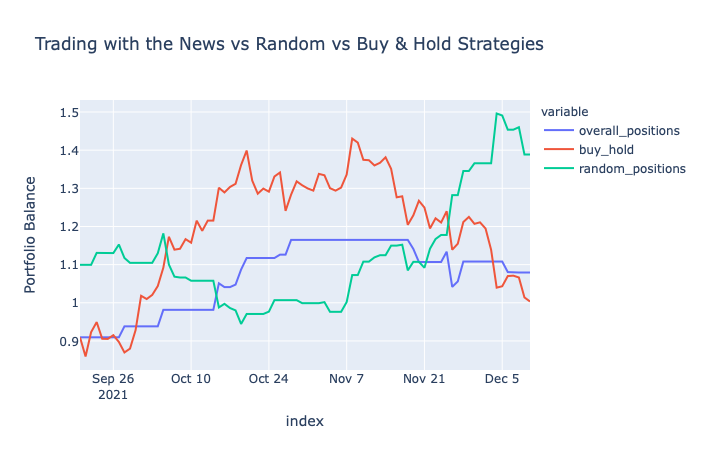

In [170]:
# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='Trading with the News vs Random vs Buy & Hold Strategies',
    labels={"value": "Portfolio Balance",
            "date": "Date"}
)

fig.show()